# Tensorflow Speech Recognition Challenge


Formulation of the problem:

We are given a dataset of 64721 <=1 sec wav files, that should be classified into one of [yes, no, up, down, left, right, on, off, stop, go, silence, unknown]/. Most of the files are "unknown" in terms of these labels
I think that the dataset of this audio length and the number of classes to predict can be treated as really simple for modern speech recognition. Probably SOTA networks can classify it almost perfectly. But let's assume we are solving a real problem: a simple set of words can be used for voice control of some application, and additionally the person who gave me this task, wrote that solution on pure TensorFlow is preferable. It means that created solution probably will be ported into another platform with TensorFlow support. Looks like our speech recognition system will be run locally in a browser or maybe a mobile application, so let's include computational effectiveness and prediction speed in our list of priorities.

Additionally, I would say that this is my first experience in speech recognition and I do not have a background in signal processing, so this task is especially interesting for me.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc">
  <ul class="toc-item">
    <li><span><a href="#Tensorflow-Speech-Recognition-Challenge" data-toc-modified-id="Tensorflow-Speech-Recognition-Challenge-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Tensorflow Speech Recognition Challenge</a></span></li>
    <li>
      <span><a href="#Preparation" data-toc-modified-id="Preparation-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Preparation</a></span>
      <ul class="toc-item">
        <li>
          <span><a href="#Metadata-exploration" data-toc-modified-id="Metadata-exploration-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Metadata exploration</a></span>
          <ul class="toc-item">
            <li><span><a href="#Bitrate-and-length" data-toc-modified-id="Bitrate-and-length-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>Bitrate and length</a></span></li>
            <li><span><a href="#Validation-and-training-lists" data-toc-modified-id="Validation-and-training-lists-2.1.2"><span class="toc-item-num">2.1.2&nbsp;&nbsp;</span>Validation and training lists</a></span></li>
            <li><span><a href="#Classes-balance" data-toc-modified-id="Classes-balance-2.1.3"><span class="toc-item-num">2.1.3&nbsp;&nbsp;</span>Classes balance</a></span></li>
          </ul>
        </li>
        <li><span><a href="#Data-preparation" data-toc-modified-id="Data-preparation-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Data preparation</a></span></li>
      </ul>
    </li>
    <li>
      <span><a href="#Modeling" data-toc-modified-id="Modeling-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Modeling</a></span>
      <ul class="toc-item">
        <li><span><a href="#Approaches-overview:" data-toc-modified-id="Approaches-overview:-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Approaches overview</a></span></li>
        <li><span><a href="#Preprocessing-Pipeline" data-toc-modified-id="Preprocessing-Pipeline-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Preprocessing Pipeline</a></span></li>
        <li><span><a href="#Nearest-neighbors-by-spectrogram" data-toc-modified-id="Nearest-neighbors-by-spectrogram-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Nearest neighbors by spectrogram</a></span></li>
        <li><span><a href="#CNN-from-scratch-(Keras)" data-toc-modified-id="CNN-from-scratch-(Keras)-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>CNN from scratch (Keras)</a></span></li>
        <li><span><a href="#Little-overview-of-pretrained-model-approach---DeepSpeech2" data-toc-modified-id="Little-overview-of-pretrained-model-approach---DeepSpeech2-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Little overview of pretrained model approach - DeepSpeech2</a></span></li>
        <li><span><a href="#Conclusions" data-toc-modified-id="Conclusions-3.6"><span class="toc-item-num">3.6&nbsp;&nbsp;</span>Conclusions</a></span></li>
      </ul>
    </li>
  </ul>
</div>

# Preparation

In this section I'm performing routine work with new data such as checking classes balance, defining train-val-test split and creating new silence and reducing unknown labels. Finally, all the data was moved into new folders, which is easy to load into any machine learning framework.

In [1]:
%%capture
# unzip data
!apt install --assume-yes p7zip-full
!mkdir /kaggle/temp; cd /kaggle/temp && 7z x /kaggle/input/tensorflow-speech-recognition-challenge/train.7z

## Metadata exploration

In [2]:
import numpy as np
import pandas as pd
from scipy.io import wavfile
import IPython.display as ipd
import os

In [3]:
DATA_PATH = '/kaggle/temp/train'
print(os.listdir(DATA_PATH))

['LICENSE', 'README.md', 'validation_list.txt', 'audio', 'testing_list.txt']


In [4]:
audio_path = os.path.join(DATA_PATH, 'audio')

data_labels = os.listdir(audio_path)
data_labels.remove('_background_noise_')
print(f'Number of labels: {len(data_labels)}')

LABELS = ['yes', 'no', 'up', 'down', 'left', 'right',
          'on', 'off', 'stop', 'go', 'silence', 'unknown']

data_file_labels = dict()
for label in data_labels:
    files = os.listdir(audio_path + '/' + label)
    for f in files:
        data_file_labels[label + '/' + f] = label

meta_df = pd.DataFrame.from_dict(data_file_labels, orient='index')
meta_df = meta_df.reset_index(drop=False)
meta_df = meta_df.rename(columns={'index': 'filepath', 0: 'folder'})
meta_df = meta_df[['folder', 'filepath']]
meta_df = meta_df.sort_values('filepath')
meta_df = meta_df.reset_index(drop=True)
print(meta_df.shape)

def remove_label_from_file(label, fname):
    return fname[len(label)+1:]

meta_df['file'] = meta_df.apply(lambda x: remove_label_from_file(*x), axis=1)
meta_df[['speaker', 'utterance']] = meta_df['file'].str.split('_', expand=True)[[0, 2]]
meta_df['label'] = meta_df['folder'].apply(lambda x: x if x in LABELS else 'unknown')

def get_wv_metadata(filename):
    bitrate, data = wavfile.read(filename)
    return bitrate, len(data)

paths = meta_df['filepath'].apply(lambda x: os.path.join(audio_path, x))
meta_df[['bitrate', 'length']] = paths.apply(get_wv_metadata).to_list()
meta_df.sample(5)

Number of labels: 30
(64721, 2)


,folder,filepath,file,speaker,utterance,label,bitrate,length
14073,four,four/0c2ca723_nohash_1.wav,0c2ca723_nohash_1.wav,0c2ca723,1.wav,unknown,16000,16000
16156,four,four/e6515415_nohash_0.wav,e6515415_nohash_0.wav,e6515415,0.wav,unknown,16000,16000
18654,go,go/f804cbb3_nohash_0.wav,f804cbb3_nohash_0.wav,f804cbb3,0.wav,go,16000,16000
5306,dog,dog/14775481_nohash_0.wav,14775481_nohash_0.wav,14775481,0.wav,unknown,16000,16000
55564,two,two/df280250_nohash_0.wav,df280250_nohash_0.wav,df280250,0.wav,unknown,16000,16000


#### Bitrate and length

In [5]:
meta_df.describe(include=np.number)

,bitrate,length
count,64721.0,64721.000000
mean,16000.0,15753.317687
std,0.0,951.750042
min,16000.0,5945.000000
25%,16000.0,16000.000000
50%,16000.0,16000.000000
75%,16000.0,16000.000000
max,16000.0,16000.000000


We have the same bitrate, but length sometimes is less than 1 sec. I'm going to fix that during preprocessing stage.

#### Validation and training lists
We are already given with lists of validation and testing samples. Let's check if they are constructed in an appropriate way, with respect to speakers. It is important because our model can overfit to speaker's voice or background sounds, and we should be able to catch sight of it.

In [6]:
validation_list = pd.read_csv(os.path.join(DATA_PATH, 'validation_list.txt'), header=None, squeeze=True).to_list()
testing_list = pd.read_csv(os.path.join(DATA_PATH, 'testing_list.txt'), header=None, squeeze=True).to_list()

meta_df['validation'] = meta_df['filepath'].isin(validation_list).astype('int')
meta_df['test'] = meta_df['filepath'].isin(testing_list).astype('int')

train_idx = (meta_df['validation']==0) & (meta_df['test']==0)
val_idx = (meta_df['validation']==1)
test_idx = (meta_df['test']==1)

In [7]:
meta_df[val_idx & test_idx]

,folder,filepath,file,speaker,utterance,label,bitrate,length,validation,test


In [8]:
train_speakers = set(meta_df.loc[train_idx, ['folder', 'speaker']].sum(axis=1))
val_speakers = set(meta_df.loc[val_idx, ['folder', 'speaker']].sum(axis=1))
test_speakers = set(meta_df.loc[test_idx, ['folder', 'speaker']].sum(axis=1))

def set_intersect(left, right):
    '''A∩B = A\(A\B)'''
    return left - (left - right)

len(set_intersect(train_speakers, val_speakers)), len(set_intersect(train_speakers, test_speakers)), len(set_intersect(val_speakers, test_speakers))

(0, 0, 0)

Great, speakers sets do not intersect, that means we can use this predefined split for model validation.

#### Classes balance

In [9]:
class_counts = pd.DataFrame([
    meta_df.loc[train_idx, 'label'].value_counts(),
    meta_df.loc[val_idx, 'label'].value_counts(),
    meta_df.loc[test_idx, 'label'].value_counts()
], index=['train', 'validation', 'test'])
class_counts

,unknown,stop,on,go,yes,no,right,up,down,left,off
train,32550,1885,1864,1861,1860,1853,1852,1843,1842,1839,1839
validation,4221,246,257,260,261,270,256,260,264,247,256
test,4268,249,246,251,256,252,259,272,253,267,262


In [10]:
class_counts.sum(axis=1)

train         51088
validation     6798
test           6835
dtype: int64

In [11]:
mean_class_samples = class_counts.drop(columns='unknown').mean(axis=1).round().astype('int')

mean_class_samples

train         1854
validation     258
test           257
dtype: int64

Classes have a similar number of samples, except 'unknown', which contains all the other words that we do not need to classify.

Also the "silence" class should be created, let's check the \_background_noise_ folder

In [12]:
bg_noise = os.path.join(audio_path, '_background_noise_')
silence_filepath = os.listdir(bg_noise)
silence_filepath = [x for x in silence_filepath if x[-3:]=='wav']
noise_df = pd.DataFrame([get_wv_metadata(os.path.join(bg_noise, x)) for x in silence_filepath], columns=['bitrate', 'length'])
noise_df['filename'] = silence_filepath
noise_df

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:32: WavFileWarning: Chunk (non-data) not understood, skipping it.


,bitrate,length,filename
0,16000,1522930,doing_the_dishes.wav
1,16000,988891,dude_miaowing.wav
2,16000,978488,running_tap.wav
3,16000,960000,pink_noise.wav
4,16000,960000,white_noise.wav
5,16000,980062,exercise_bike.wav


It's hard, to choose validation split for this class. For example, let's split each file into three disjoint parts (train-val-test, 80:10:10), and the create a samples with the moving window

## Data preparation
Move validation and test into separate directories, create 'silence' samples, thin out 'unknown'

In [13]:
def sample_unknown(df, num_leave, random_state=567):
    '''
    Reduce number of rows with label=='unknown'
    uniformly sampling from the unknown-labeled folders.
    
    df - dataframe with metadata
    num_leave - how many samples should be chosen
    random_state - random sedd for pd.DataFrame.sample
    
    Returns np.array of df indicies
    '''
    redundant_labels = df.loc[df['label']=='unknown', 'folder'].unique()
    num_leave_per_label = num_leave // len(redundant_labels) + 1
    indexlist = [df[df['folder']==l].sample(num_leave_per_label, random_state=random_state).index for l in redundant_labels]
    return np.array(indexlist).ravel()

idx_to_keep = np.hstack([
    sample_unknown(meta_df[train_idx], mean_class_samples['train']),
    sample_unknown(meta_df[val_idx], mean_class_samples['validation']),
    sample_unknown(meta_df[test_idx], mean_class_samples['test']),
    meta_df[meta_df['label']!='unknown'].index
])
meta_df = meta_df.loc[idx_to_keep]

In [14]:
import itertools
from pathlib import Path

DATASET_PATH = '/kaggle/temp/data'
TRAIN_DATASET_PATH = os.path.join(DATASET_PATH, 'train')
VAL_DATASET_PATH = os.path.join(DATASET_PATH, 'validation')
TEST_DATASET_PATH = os.path.join(DATASET_PATH, 'test')

for dataset, label in itertools.product([TRAIN_DATASET_PATH, VAL_DATASET_PATH, TEST_DATASET_PATH], LABELS):
    Path(os.path.join(dataset, label)).mkdir(parents=True, exist_ok=True)

In [15]:
# Move files into new directories
def move_files(df, dataset_dir):
    for i, row in df.iterrows():
        cur_path = os.path.join(audio_path, row['filepath'])
        new_path = os.path.join(dataset_dir, row['label'], f"{i}_{row['file']}")
        os.replace(cur_path, new_path)

move_files(meta_df[(meta_df['validation']==0) & (meta_df['test']==0)], TRAIN_DATASET_PATH)
move_files(meta_df[meta_df['validation']==1], VAL_DATASET_PATH)
move_files(meta_df[meta_df['test']==1], TEST_DATASET_PATH)

In [16]:
train_silence_path = os.path.join(TRAIN_DATASET_PATH, 'silence')
val_silence_path = os.path.join(VAL_DATASET_PATH, 'silence')
test_silence_path = os.path.join(TEST_DATASET_PATH, 'silence')

num_samples_per_label = mean_class_samples//len(noise_df) + 1

def create_wav_samples(data, bitrate, num_samples, path):
    for x in np.linspace(0, len(data) - bitrate - 1, num_samples, dtype='int'):
        wavfile.write(os.path.join(path, str(x)+filename), bitrate, data[x: x+bitrate])

for filename in noise_df['filename']:
    bitrate, data = wavfile.read(os.path.join(bg_noise, filename))
    split1 = int(len(data)*0.8)
    split2 = int(len(data)*0.9)
    create_wav_samples(data[:split1], bitrate, num_samples_per_label['train'], train_silence_path)
    create_wav_samples(data[split1: split2], bitrate, num_samples_per_label['validation'], val_silence_path)
    create_wav_samples(data[split2:], bitrate, num_samples_per_label['test'], test_silence_path)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: WavFileWarning: Chunk (non-data) not understood, skipping it.
  if sys.path[0] == '':


In [17]:
!rm -rf $DATA_PATH
del meta_df

Now we have nice directory hierarchy and the balanced dataset

In [18]:
!tree -d $DATASET_PATH

/kaggle/temp/data
├── test
│   ├── down
│   ├── go
│   ├── left
│   ├── no
│   ├── off
│   ├── on
│   ├── right
│   ├── silence
│   ├── stop
│   ├── unknown
│   ├── up
│   └── yes
├── train
│   ├── down
│   ├── go
│   ├── left
│   ├── no
│   ├── off
│   ├── on
│   ├── right
│   ├── silence
│   ├── stop
│   ├── unknown
│   ├── up
│   └── yes
└── validation
    ├── down
    ├── go
    ├── left
    ├── no
    ├── off
    ├── on
    ├── right
    ├── silence
    ├── stop
    ├── unknown
    ├── up
    └── yes

39 directories


# Modeling

## Approaches overview:
From speech recognition approaches two main groups can be distinguished:

_Classic speech_ recognition approaches - Hidden Markov Models, Gaussian Mixtures, other statistical models. Fast&cheap, don't require GPU for training and running. Cons: they require hard data preprocessing and feature creation based on signal decomposition, and understanding of acoustic models. In short - you should really understand the field to apply them. Also, they seem to be inaccurate on noisy data. Takes a similar place in speech recognition as non-deep methods in computer vision.

_Deep learning_. Typically deep learning is applied in an end-to-end manner, you give a sound - you receive a text. No acoustic and language models are required. Data is preprocessed with some transformations (e.g. Fourier - STFT (spectrogram)) into 2D input. From papers published in 2014-2016, we can imagine a typical deep speech recognition model as the sequence-to-sequence one that has convolutional layers at the beginning to catch whole sounds, then some recurrent layers, and the layer classifying the actual alphabet character of the input. Received prediction like "c-c--a-a-a--t-t" is mapped to actual word by combining adjacent characters (This is a part of CTC loss term).

With neural networks, we have two main ways: first - find and try (and, maybe use transfer learning, finetuning) a big pretrained model, second - develop and train a new one from scratch.
I think that training a RNN with CTC loss is a too complicated approach for such a simple task and a small dataset - we simply do not have the required variety in recordings sounds and the model leads to overfitting because some of them appear only in specific combinations.

But actually, we don't even need a speech recognition model. Because of almost the same recordings length, we can simply convert them into equal-sized spectrograms and train a convolutional classifier of the whole word - which we can do because we need to classify only 13 of them. I believe that the classification of a single word is a real-world case, for example, voice control like voice dialing in old phones, so this approach is not a competition hacking.

## Preprocessing Pipeline

In [19]:
import tensorflow as tf
from tensorflow.audio import decode_wav
from tensorflow import signal  # here is the Short-time Fourier Transform used to create a spectrograms

AUTOTUNE = tf.data.AUTOTUNE

In [20]:
def decode_audio(audio_binary):
    audio, _ = tf.audio.decode_wav(audio_binary)
    return tf.squeeze(audio, axis=-1)


def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2]


def get_waveform_and_label(file_path):
    label = get_label(file_path)
    audio_binary = tf.io.read_file(file_path)
    waveform = decode_audio(audio_binary)
    return waveform, label


def get_spectrogram(waveform):
    # Padding for files with less than 16000 samples
    zero_padding = tf.zeros([16000] - tf.shape(waveform), dtype=tf.float32)
    waveform = tf.cast(waveform, tf.float32)
    equal_length = tf.concat([waveform, zero_padding], 0)
    spectrogram = tf.signal.stft(
      equal_length, frame_length=255, frame_step=128
    )

    spectrogram = tf.abs(spectrogram)
    return spectrogram


def get_spectrogram_and_label_id(audio, label):
    spectrogram = get_spectrogram(audio)
    spectrogram = tf.expand_dims(spectrogram, -1)
    label_id = tf.argmax(label == LABELS)
    return spectrogram, label_id


def load_and_preprocess_dataset(dataset_glob):
    # actually, data loading in pytorch seem to be much more convenient for me
    filenames = tf.io.gfile.glob(dataset_glob)
    files_ds = tf.data.Dataset.from_tensor_slices(filenames)
    waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
    spectrogram_ds = waveform_ds.map(
        get_spectrogram_and_label_id, num_parallel_calls=AUTOTUNE)
    return spectrogram_ds

In [21]:
DATASET_PATH = '/kaggle/temp/data'
TRAIN_DATASET_PATH = os.path.join(DATASET_PATH, 'train')
VAL_DATASET_PATH = os.path.join(DATASET_PATH, 'validation')
TEST_DATASET_PATH = os.path.join(DATASET_PATH, 'test')
LABELS = np.array(['yes', 'no', 'up', 'down', 'left', 'right',
          'on', 'off', 'stop', 'go', 'silence', 'unknown'])

train_ds = load_and_preprocess_dataset(TRAIN_DATASET_PATH + '/*/*')
val_ds = load_and_preprocess_dataset(VAL_DATASET_PATH + '/*/*')
test_ds = load_and_preprocess_dataset(TEST_DATASET_PATH + '/*/*')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


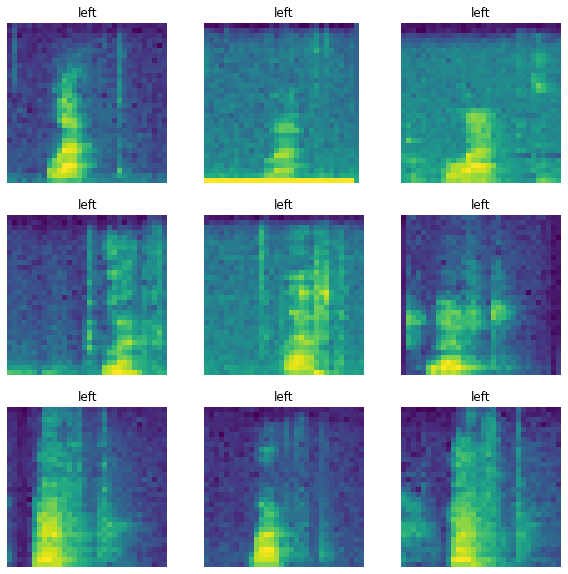

In [22]:
import matplotlib.pyplot as plt

def plot_spectrogram(spectrogram, ax):
  # Convert to frequencies to log scale and transpose so that the time is
  # represented in the x-axis (columns).
    log_spec = np.log(spectrogram.T)[::-1]
    ax.imshow(log_spec)

rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
for i, (spectrogram, label_id) in enumerate(train_ds.take(n)):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    spectrogram = tf.image.resize(spectrogram, (32, 32))
    plot_spectrogram(np.squeeze(spectrogram.numpy()), ax)
    ax.set_title(LABELS[label_id.numpy()])
    ax.axis('off')

plt.show()

## Nearest neighbors by spectrogram
The are similar patterns on same words spectrograms even by eye. So I decide to start with such simple method as kNN.

It gives 0.566 accuracy, while random guessing baseline is 1/12 = 0.083. Not bad.

I believe if spend some time on feature engineering with signal transformations (with different parameters) - score of this simple model can be hightly improved.

In [23]:
%%time
# I already created TF datasets, but it is much simpler to take knn from sklearn
def spectrogram_dataset_to_numpy(dataset):
    spectrograms = []
    labels = []
    for x, y in dataset:
        spectrograms.append(tf.image.resize(x, (32, 32)))
        labels.append(y)
    spectrograms = np.array(spectrograms).reshape(-1, 32*32)
    labels = np.array(labels)
    return spectrograms, labels

train_spectrograms, train_labels = spectrogram_dataset_to_numpy(train_ds)
val_spectrograms, val_labels = spectrogram_dataset_to_numpy(val_ds)
test_spectrograms, test_labels = spectrogram_dataset_to_numpy(test_ds)

CPU times: user 2min, sys: 4.86 s, total: 2min 4s
Wall time: 1min 7s


max validation accuracy: 0.5656239922605611


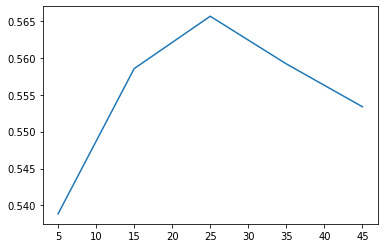

In [24]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

scores = []
ks = np.arange(5, 55, 10)
for k in ks:
    knn = KNeighborsClassifier(k, metric='cosine', n_jobs=-1)
    knn.fit(train_spectrograms, train_labels)
    knn_pred = knn.predict(val_spectrograms)
    scores.append(accuracy_score(val_labels, knn_pred))
    
plt.plot(ks, scores)
print(f'max validation accuracy: {np.max(scores)}')

In [25]:
knn = KNeighborsClassifier(25, metric='cosine', n_jobs=-1)
knn.fit(train_spectrograms, train_labels)
knn_pred = knn.predict(test_spectrograms)
print('test accuracy', accuracy_score(test_labels, knn_pred))

test accuracy 0.5705024311183144


In [26]:
del train_spectrograms, train_labels, val_spectrograms, val_labels, test_spectrograms, test_labels

## CNN from scratch (Keras)
Inspired by TensorFlow Tutorial [Simple audio recognition: Recognizing keywords](https://www.tensorflow.org/tutorials/audio/simple_audio), I also borroved some helping function from it.

Audios are converted to spectrograms with STFT (I took parameters from the tutorial), then spectrograms resized to 32x32 to reduce the feature space then used as input for CNN. Classifier constructed in a standart way - with 3x3  convolutional kernels and max pooling, then single dense outputing layer on the top.

In [27]:
from tensorflow.keras import layers, models
from tensorflow.keras.layers.experimental import preprocessing

for spectrogram, _ in train_ds.take(1):
    input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(LABELS)

resizing_layer = preprocessing.Resizing(32, 32)
# fit the scaler
norm_layer = preprocessing.Normalization()
norm_layer.adapt(train_ds.map(lambda x, _: resizing_layer(x)))

Input shape: (124, 129, 1)


In [28]:
model = models.Sequential([
    layers.Input(shape=input_shape),
    resizing_layer,
    norm_layer,
    layers.Conv2D(16, 3, padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Conv2D(16, 3, padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    
    layers.Conv2D(32, 3, padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Conv2D(48, 3, padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    
    layers.Conv2D(64, 3, padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Conv2D(128, 3, padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.GlobalMaxPooling2D(),

    layers.Flatten(),
    layers.Dropout(0.4),
    layers.Dense(num_labels),
])

model.summary()

model.compile(
    tf.keras.optimizers.Adam(1e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing (Resizing)          (None, 32, 32, 1)         0         
_________________________________________________________________
normalization (Normalization (None, 32, 32, 1)         3         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 16)        160       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 16)        64        
_________________________________________________________________
activation (Activation)      (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 16)        2320      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 16)        6

In [29]:
batch_size = 128
train_ds_batched = train_ds.cache().shuffle(len(train_ds), reshuffle_each_iteration=True).prefetch(AUTOTUNE).batch(batch_size)
val_ds_batched = val_ds.cache().prefetch(AUTOTUNE).batch(batch_size)

EPOCHS = 100
history = model.fit(
    train_ds_batched, 
    validation_data=val_ds_batched,  
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping('val_accuracy', verbose=1, patience=5, restore_best_weights=True),
)

Epoch 1/100
174/174 [==============================] - 58s 50ms/step - loss: 4.8365 - accuracy: 0.0967 - val_loss: 2.4063 - val_accuracy: 0.1728
Epoch 2/100
174/174 [==============================] - 2s 11ms/step - loss: 2.9448 - accuracy: 0.1194 - val_loss: 2.3224 - val_accuracy: 0.1999
Epoch 3/100
174/174 [==============================] - 2s 11ms/step - loss: 2.5615 - accuracy: 0.1416 - val_loss: 2.3101 - val_accuracy: 0.2122
Epoch 4/100
174/174 [==============================] - 2s 12ms/step - loss: 2.4368 - accuracy: 0.1500 - val_loss: 2.2976 - val_accuracy: 0.2128
Epoch 5/100
174/174 [==============================] - 2s 11ms/step - loss: 2.3573 - accuracy: 0.1729 - val_loss: 2.2591 - val_accuracy: 0.2525
Epoch 6/100
174/174 [==============================] - 2s 11ms/step - loss: 2.2594 - accuracy: 0.2068 - val_loss: 2.1606 - val_accuracy: 0.3241
Epoch 7/100
174/174 [==============================] - 2s 11ms/step - loss: 2.2155 - accuracy: 0.2351 - val_loss: 2.0489 - val_accuracy

0.89-0.90 on validation

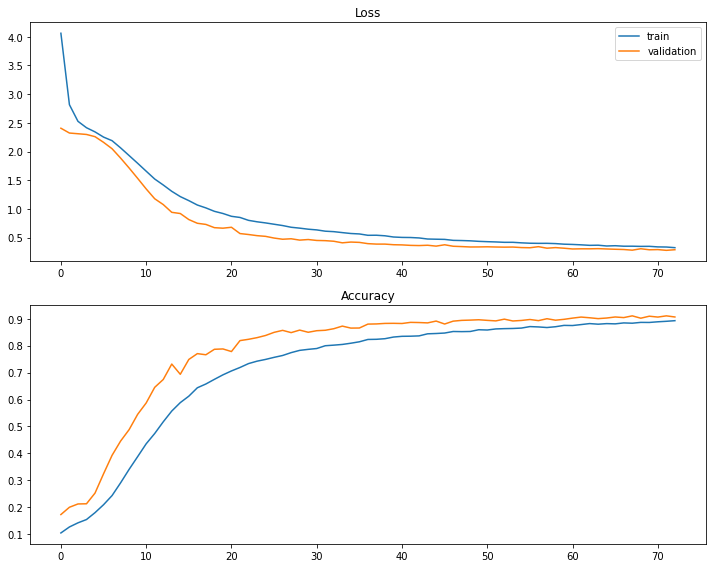

In [30]:
fig, axs = plt.subplots(2, 1, tight_layout=True, figsize=(10, 8))
axs[0].set_title('Loss')
axs[1].set_title('Accuracy')
axs[0].plot(history.history['loss'], label='train')
axs[0].plot(history.history['val_loss'], label='validation')
axs[1].plot(history.history['accuracy'], label='train')
axs[1].plot(history.history['val_accuracy'], label='validation')
axs[0].legend();

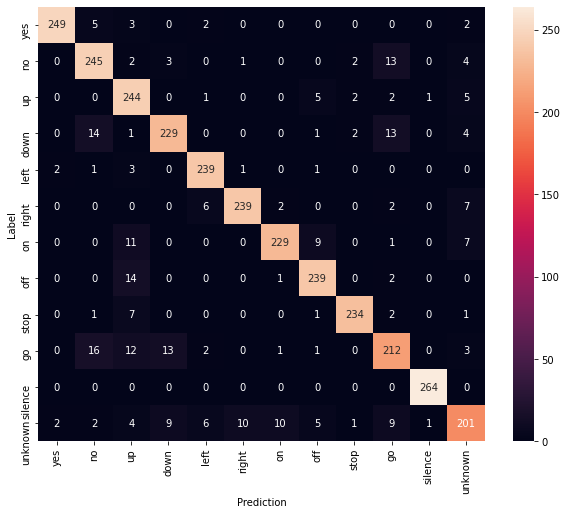

In [31]:
import seaborn as sns
test_audio = []
test_labels = []

for audio, label in val_ds:
    test_audio.append(audio.numpy())
    test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)
    
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels
    
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=LABELS, yticklabels=LABELS, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

Model often misclassify "go" and "no". Also model badly predict "unknown", it could be assumed - its hard to train model predict such thing in supervised way.

In [32]:
model.evaluate(test_ds.batch(64))

49/49 [==============================] - 6s 122ms/step - loss: 0.2816 - accuracy: 0.9112


[0.2816479504108429, 0.9111831188201904]

## Little overview of pretrained model approach - DeepSpeech2

Classic situation: this package does not have documentation. I decided to hastily create this little code snippet to try the model, but if will need the same model in production, we can reimplement it manually, and then load the weights.

In [33]:
%%capture
!pip install tables google-cloud-storage python-speech-features
!git clone https://github.com/rolczynski/Automatic-Speech-Recognition.git
!mv Automatic-Speech-Recognition/automatic_speech_recognition automatic_speech_recognition
!rm -rf Automatic-Speech-Recognition

In [34]:
import automatic_speech_recognition as asr

pipeline = asr.load('deepspeech2', lang='en')
pipeline.model.summary()

Model: "DeepSpeech2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
X (InputLayer)               [(None, None, 160)]       0         
_________________________________________________________________
lambda (Lambda)              (None, None, 160, 1)      0         
_________________________________________________________________
conv_1 (Conv2D)              (None, None, 80, 32)      14432     
_________________________________________________________________
conv_1_bn (BatchNormalizatio (None, None, 80, 32)      128       
_________________________________________________________________
conv_1_relu (ReLU)           (None, None, 80, 32)      0         
_________________________________________________________________
conv_2 (Conv2D)              (None, None, 40, 32)      236544    
_________________________________________________________________
conv_2_bn (BatchNormalizatio (None, None, 40, 32)      

In [35]:
from tqdm.auto import tqdm

val_filenames = tf.io.gfile.glob(VAL_DATASET_PATH + '/*/*')
deepspeech_pred = []
true_labels = []

for file in tqdm(val_filenames[:25]):
    deepspeech_pred.append(pipeline.predict([asr.utils.read_audio(file)]))
    true_labels.append(get_label(file))

  0%|          | 0/25 [00:00<?, ?it/s]

In [36]:
np.array(deepspeech_pred).ravel()

array(['', 'right', 'right', 'crit', 'right', 'rate', 'right', 'right',
       'right', 'right', 'what', 'right', 'ritinon', 'gray', 'whom',
       'mi too', 'eright', 'right', 'riht', 'words', 'right', 'wright',
       'right', 'right', 'ra'], dtype='<U7')

In [37]:
!rm -rf automatic_speech_recognition

It seems to work good, especially if we will finetune it, and maybe, use some heuristic based on Levenshtein distance to correct outputs.

But this is really big and slow even on GPU, so it's not the case for task we are trying to solve.

## Conclusions

I tried three methods for this task, but there is still a big room for improvement.

**Nearest Neighbors**:
- Pros:
   - Fast & simple
   - Understandable mechanism - no pitfalls
- Cons:
    - Training set should be stored on a production platform
    - Quite inaccurate
- Ways for improvement:
    - kNN shows that distance-based methods can have a chance, so maybe some clustering should be performed, and applied for the test set as "k nearest centroids"
    - Create additional features. There is a variety of decompositions in signal processing, also they have a lot of parameters, like window type and window size. Just need to find appropriate.
        
**CNN**:
- Pros:
    - the best model for now
    - still simple enough
- Cons:
    - some systematic misclassification
- Ways for improvement:
    - Additional data. I think these one-word commands can be found in other datasets.
    - Data augmentation. We can apply various sound effects to expand our dataset: pitch, reverb, compression, distortion, changing a loudness, adding a background noise...
    - Dealing with "unknown" label. The actual detection of the unknown is not even close to perfect. I think that there must another way to implement detection of new words, maybe with clustering of the last convolutional layer output.
        
**Pretrained models**:
- Pros:
    - I think they can give a pretty good prediction if we spent some time on pipeline organization
- Cons:
    - Heavy. Spend more than 1.5 sec for a single prediction on GPU
    - Output requires additional processing
- Ways for improvement:
    - Perform research of existing speech recognition models. Find the best for our task
    - Creating algorithm for labels fixing
    - Finetuning
        
The next step should be rewriting the model pure TensorFlow (but unfortunately, I have no time left for this) and deploying the best model to "production" (test on a competition) 

In [ ]:
%%capture
!cd /kaggle/temp && 7z x /kaggle/input/tensorflow-speech-recognition-challenge/test.7z

In [ ]:
TEST_PATH = 'kaggle/temp/test/*'
test_ds = load_and_preprocess_dataset(TEST_PATH)
fnames = tf.io.gfile.glob(TEST_PATH)

test_pred = model.predict(test_ds)

subm = pd.DataFrame({'fname': fnames, 'label': test_pred})
subm['label'] = LABELS[subm['label']]
subm.to_csv('submission.csv')